# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### *** YOUR ID HERE ***

---
---


In [1]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

np.random.seed(42)

# Design your algorithm

### Overview
Our implementation of AdaBoost follows the algorithm described in *"The Elements of Statistical Learning"* by Hastie, Tibshirani, and Friedman. AdaBoost is an ensemble method that combines multiple weak learners (e.g., decision stumps) to create a strong classifier.


### **Design and Theoretical Considerations**

1. **Initialization:**
   - The sample weights $w_i$ are initialized uniformly:
     $w_i = \frac{1}{N}, \quad i = 1, \dots, N$
     where $N$ is the number of training samples.

2. **Iterative Boosting Steps:**
   For $t = 1, \dots, T$ (where $T$ is the number of iterations):
   - Train a weak learner $G_t$ (in our case, a decision tree with `max_depth=1` by default. This is a hyperparameter like in sklearn's implementation).
   - Compute the weighted classification error:
     $\text{error}_t = \frac{\sum_{i=1}^N w_i \cdot I(y_i \neq G_t(x_i))}{\sum_{i=1}^N w_i}$
     where $I$ is the indicator function.
   - Calculate the weight of the weak learner (alpha):
     $\alpha_t = \log\left(\frac{1 - \text{error}_t}{\text{error}_t}\right)$
   - Update the sample weights to focus more on misclassified samples:
     $w_i \leftarrow w_i \cdot \exp\left(\alpha_t \cdot I(y_i \neq G_t(x_i))\right)$
   - Normalize the weights so they sum to 1 to prevent numerical instability. This is one place where we deviate from the theoretical implementation as described in the book, and use practical tools for numerical stability, like in sklearn.

3. **Final Prediction:**
   The final model aggregates the predictions of all weak learners using their corresponding weights $\alpha_t$:
   $G(x) = \text{sign}\left(\sum_{t=1}^T \alpha_t \cdot G_t(x)\right)$


### **Practical Implementation Details**
- **Weak Learners:**
  We use decision trees with `max_depth=1` (decision stumps) as our weak learners by default, but the depth can be adjusted using the `learning_depth` parameter.

- **Hyperparameters:**
  - **T (Number of Iterations):** Controls how many weak learners are combined. A larger $T$ can reduce bias but may increase overfitting.
  - **Learning Depth:** The complexity of each weak learner. Stumps (depth=1) are simple but effective for most cases.

- **Stopping Condition:**
  If the weighted error of a weak learner is $\geq 0.5$, the learner is skipped and the learning is finished, as its performance is no better than random guessing. This is the second place where we use practical tools for enhanced learning and follow sklearn implementation.


### **Limitations**
1. **Overfitting:**
   If the number of iterations $T$ is too high, AdaBoost may overfit noisy or mislabeled data.
2. **Weak Learners:**
   AdaBoost relies on weak learners with error rates $< 0.5$. If the weak learners are too complex, it undermines AdaBoost's principle of "boosting weak models."
3. **Outliers:**
   AdaBoost is sensitive to outliers, as it assigns higher weights to misclassified samples.


### **Use-Cases**
- Binary classification problems with structured data.
- Applications where combining simple classifiers improves performance, highly useful for many usecases.


### **Optimization Strategies**
- **Weight Normalization:** We normalize the weights at each iteration to ensure numerical stability.
- **Efficient Weak Learners:** Using `DecisionTreeClassifier` with `max_depth=1` ensures the weak learners are computationally efficient.


### **Conclusion**
Our implementation adheres strictly to the theoretical formulation of AdaBoost as outlined in *"The Elements of Statistical Learning"*. It captures the initialization, weight updates, and iterative boosting steps, providing a clear and robust design which optimized using the practical knowledge from sklearn library.


# Your implementations

In [2]:
# Your code here
# Part 1: Implementing AdaBoost
class AdaBoostCustom:
    def __init__(self, T):
        self.T = T
        self.alphas = []
        self.models = []
        # Note: You may add more attributes

    def fit(self, X, y, learning_depth=1):
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples

        for t in range(self.T):
            model = DecisionTreeClassifier(max_depth=learning_depth)
            model.fit(X, y, sample_weight=weights)
            predictions = model.predict(X)

            error = self.calculate_error(predictions, y, weights)
            if error >= 0.5:
                break

            alpha = self.calculate_new_alpha(error)
            weights = self.calculate_weights(weights, alpha, y, predictions)

            self.models.append(model)
            self.alphas.append(alpha)

            # Print training error for the entire model
            full_model_predictions = self.predict(X)
            full_model_error = np.mean(full_model_predictions != y)
            print(f"Iteration {t+1}, Full Model Training Error: {full_model_error:.4f}")
    
    def predict(self, X):  
        final_predictions = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            final_predictions += alpha * model.predict(X)
        return np.sign(final_predictions)

    @staticmethod
    def calculate_error(predictions, y, weights):
        return np.sum(weights * (predictions != y)) / np.sum(weights)

    @staticmethod
    def calculate_new_alpha(error):
        return np.log((1 - error) / error)

    @staticmethod
    def calculate_weights(weights, alpha, y, predictions):
        weights = weights * np.exp(alpha * (predictions != y))
        return weights / np.sum(weights)

# Generate Data
We decided to work with sklearn's `make_classification` library, which allows generating classification data with varying complexities and correlations. We focus on binary classification settings and conducted four experiments on two different dataset configurations to demonstrate various aspects of the AdaBoost algorithm and to validate that our implementation is correct and functioning as expected.

The first dataset contains a single feature and is designed to showcase the accuracy of our algorithm's implementation. Interestingly, we observed that boosting stumps struggles to perfectly fit the data (achieve 0 training error) because the lack of additional features prevents multiple stumps from better separating the data. We also compared our results with sklearn's AdaBoost implementation to ensure the correctness of our approach.

The second dataset is more complex, consisting of 8 features, where 7 are informative and one is redundant. This configuration allowed us to analyze how AdaBoost handles complex data and how it improves the performance of weak learners.


### Experiment 1
For a warmup, let's generate data with only 1 feature. We would expect a single stump to provide a solid result.

In [3]:
# Generate simple synthetic data
# Only 1 feature
X, y = make_classification(n_samples=2000, n_features=1, n_informative=1, n_redundant=0, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Test data')

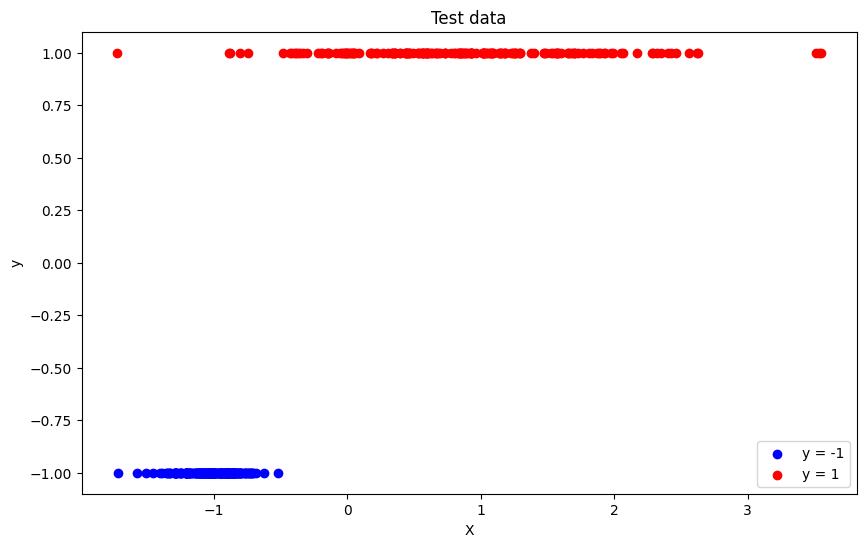

In [5]:
# Visualize data
plt.figure(figsize=(10, 6))
X_scatter = X_test
Y_scater = y_test
plt.scatter(X_scatter[Y_scater == -1], Y_scater[Y_scater == -1], color='b', label='y = -1')
plt.scatter(X_scatter[Y_scater == 1], Y_scater[Y_scater == 1], color='r', label='y = 1')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title("Test data")

Text(0.5, 1.0, 'Train data')

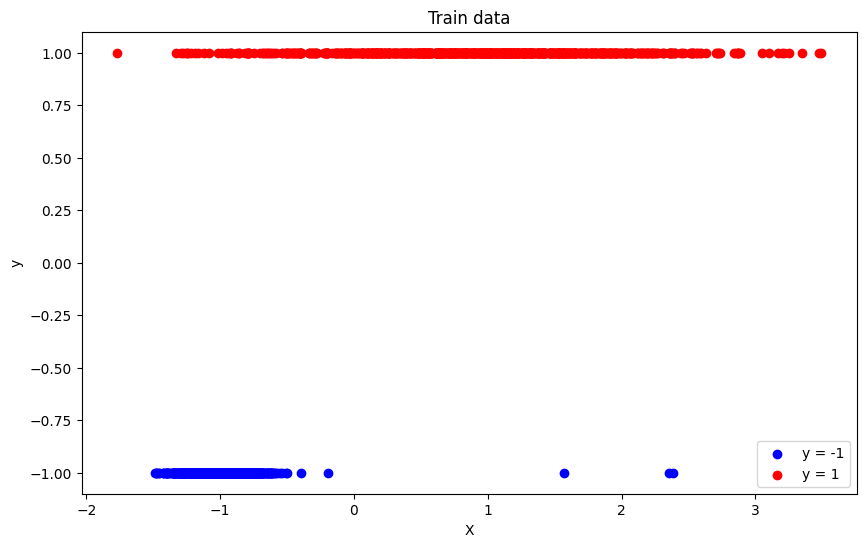

In [6]:
# Visualize data
plt.figure(figsize=(10, 6))
X_scatter = X_train
Y_scater = y_train
plt.scatter(X_scatter[Y_scater == -1], Y_scater[Y_scater == -1], color='b', label='y = -1')
plt.scatter(X_scatter[Y_scater == 1], Y_scater[Y_scater == 1], color='r', label='y = 1')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title("Train data")

In [7]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=1)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0306
Iteration 2, Full Model Training Error: 0.0306
Iteration 3, Full Model Training Error: 0.0306
Iteration 4, Full Model Training Error: 0.0306
Iteration 5, Full Model Training Error: 0.0306
Iteration 6, Full Model Training Error: 0.0306
Iteration 7, Full Model Training Error: 0.0306
Iteration 8, Full Model Training Error: 0.0306
Iteration 9, Full Model Training Error: 0.0306
Iteration 10, Full Model Training Error: 0.0306
Iteration 11, Full Model Training Error: 0.0306
Iteration 12, Full Model Training Error: 0.0306
Iteration 13, Full Model Training Error: 0.0306
Iteration 14, Full Model Training Error: 0.0306
Iteration 15, Full Model Training Error: 0.0306
Iteration 16, Full Model Training Error: 0.0306
Iteration 17, Full Model Training Error: 0.0306
Iteration 18, Full Model Training Error: 0.0306
Iteration 19, Full Model Training Error: 0.0306
Iteration 20, Full Model Training Error: 0.0306
Iteration 21, Full Model Training Error: 0.0306
I

In [8]:
# Compare with sklearn's AdaBoost
sklearn_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42, algorithm="SAMME")
sklearn_adaboost.fit(X_train, y_train)
y_pred = sklearn_adaboost.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.9850


In [9]:
# Observe sklearn adaboost's alphas
sklearn_adaboost.estimator_weights_

array([3.45483487, 0.73909707, 0.69149328, 0.23681201, 0.31273112,
       0.38290584, 0.28064931, 0.28187321, 0.20752194, 0.29682267,
       0.25824999, 0.187532  , 0.16336836, 0.36210729, 0.29268633,
       0.18477905, 0.0417905 , 0.04093503, 0.12118899, 0.20659845,
       0.21254523, 0.14140258, 0.04044268, 0.03964098, 0.03887044,
       0.0381293 , 0.0374159 , 0.0375447 , 0.0368528 , 0.03675413,
       0.03609081, 0.03620997, 0.03556598, 0.03547386, 0.03485556,
       0.03496611, 0.10486476, 0.09898051, 0.03506187, 0.03445773,
       0.03387406, 0.03378121, 0.03322005, 0.03332854, 0.0327822 ,
       0.03269509, 0.03216916, 0.03227045, 0.03175798, 0.03167611])

In [10]:
# Observe custom adaboost's alphas
custom_adaboost.alphas

[np.float64(3.4548348650659118),
 np.float64(0.7390970707518009),
 np.float64(0.6914932839957402),
 np.float64(0.23681201126741028),
 np.float64(0.3127311205859686),
 np.float64(0.38290583693348484),
 np.float64(0.2806493065815364),
 np.float64(0.2818732080539556),
 np.float64(0.2075219351630782),
 np.float64(0.29682267134647733),
 np.float64(0.2582499949367514),
 np.float64(0.1875320002925372),
 np.float64(0.16336835903732003),
 np.float64(0.36210729278829046),
 np.float64(0.2926863329723157),
 np.float64(0.18477904928672853),
 np.float64(0.04179049849799071),
 np.float64(0.04093502892210119),
 np.float64(0.12118898503276086),
 np.float64(0.20659844781205),
 np.float64(0.2125452269895821),
 np.float64(0.14140257534915682),
 np.float64(0.04044267568944844),
 np.float64(0.03964097504285486),
 np.float64(0.038870444941495025),
 np.float64(0.03812930194480958),
 np.float64(0.0374158961356564),
 np.float64(0.037544698109773615),
 np.float64(0.03685280462629672),
 np.float64(0.0367541257152

In [11]:
for i in range(len(custom_adaboost.models)):
    print(custom_adaboost.models[i].tree_.threshold[0])

-0.5395399928092957
-0.8126893937587738
-0.8126893937587738
-1.2197956442832947
2.3324782848358154
-0.19317543506622314
2.3324782848358154
-1.163835883140564
1.5664371848106384
-0.19317543506622314
1.5664371848106384
-0.9551257193088531
-0.5408677160739899
-0.19317543506622314
-0.5408677160739899
2.383428931236267
2.383428931236267
2.383428931236267
2.3324782848358154
-0.19317543506622314
1.5664371848106384
2.383428931236267
2.383428931236267
2.383428931236267
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341
2.3324782848358154
2.383428931236267
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341
2.383428931236267
2.383428931236267
-1.630308449268341
-1.630308449268341


In [12]:
# Train a 1 depth decision tree
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
y_pred = stump.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9850


In [13]:
# The stump threshold
stump.tree_.threshold[0]

np.float64(-0.5395399928092957)

#### Key observations:
1. **Single Stump Performance:**
   The single stump provides competitive results compared to the AdaBoost model. This is expected since the data is simple and can be easily separated by a single decision boundary. Although AdaBoost can achieve 0 training error by combining multiple stumps, the single stump's performance suggests that the data is straightforward. Since there is only one feature, the stumps may struggle to improve upon the first stump's decision boundary. This limitation will be explored in the next experiment.

2. **Sanity Check - Initial Stump Comparison:**
   The stump's decision boundary is equal to the decision boundary of the first model used in the AdaBoost ensemble.

3. **Sanity Check - Alpha Values:**
   The alphas are all positive, as expected, since the training error of each weak learner is less than 0.5. The alpha values adjust according to the current iteration's error.

4. **Decision Boundary Evolution:**
   The decision boundaries of the stumps change throughout the AdaBoost process due to the adaptive weight adjustments applied to the training samples.

5. **Overall Performance:**
   Overall, the custom AdaBoost implementation seems to work well. We will further explore some interesting characteristics of the model in future experiments.

6. **Comparison to sklearn's AdaBoost:**
The custom AdaBoost implementation and sklearn's AdaBoost provide similar results, and similar alphas (estimator weights). We followed the implementation existing in  "The Elements of Statistical Learning" book, which is also implemented in sklearn. The results are as expected.


### Experiment 2
Let's explore what happens if we provide a stronger weak learner to that single feature data.

In [14]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=70)
custom_adaboost.fit(X_train, y_train, learning_depth=5) # The depth of the weak learners increased
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0256
Iteration 2, Full Model Training Error: 0.0256
Iteration 3, Full Model Training Error: 0.0256
Iteration 4, Full Model Training Error: 0.0231
Iteration 5, Full Model Training Error: 0.0256
Iteration 6, Full Model Training Error: 0.0269
Iteration 7, Full Model Training Error: 0.0238
Iteration 8, Full Model Training Error: 0.0250
Iteration 9, Full Model Training Error: 0.0225
Iteration 10, Full Model Training Error: 0.0225
Iteration 11, Full Model Training Error: 0.0225
Iteration 12, Full Model Training Error: 0.0200
Iteration 13, Full Model Training Error: 0.0213
Iteration 14, Full Model Training Error: 0.0206
Iteration 15, Full Model Training Error: 0.0169
Iteration 16, Full Model Training Error: 0.0169
Iteration 17, Full Model Training Error: 0.0138
Iteration 18, Full Model Training Error: 0.0156
Iteration 19, Full Model Training Error: 0.0156
Iteration 20, Full Model Training Error: 0.0131
Iteration 21, Full Model Training Error: 0.0150
I

In [15]:
custom_adaboost.alphas

[np.float64(3.638227802353468),
 np.float64(1.7514928172494095),
 np.float64(1.583533596623304),
 np.float64(1.132854842642716),
 np.float64(1.1136277608278942),
 np.float64(0.8261779466405413),
 np.float64(0.7762219236351751),
 np.float64(0.7682098406476532),
 np.float64(0.7405086221995003),
 np.float64(0.6512412258053489),
 np.float64(0.8812219766843369),
 np.float64(0.5895432244429403),
 np.float64(0.42977850923209654),
 np.float64(0.4211951743907896),
 np.float64(0.5536091695191193),
 np.float64(0.6873843325163038),
 np.float64(0.5825569753634403),
 np.float64(0.4224954246475911),
 np.float64(0.4088976249591764),
 np.float64(0.5600140148516514),
 np.float64(0.5369809191805295),
 np.float64(0.40610057037590874),
 np.float64(0.4990712011829074),
 np.float64(0.440332526383097),
 np.float64(0.41729971869118776),
 np.float64(0.5173960869991865),
 np.float64(0.4167046238660069),
 np.float64(0.5008128487688238),
 np.float64(0.5321345656224533),
 np.float64(0.40521194946175576),
 np.float6

In [16]:
for i in range(5):
    print(custom_adaboost.models[0].tree_.threshold[i])

-0.5395399928092957
-0.6832429468631744
-1.630308449268341
-2.0
-0.8126893937587738


In [17]:
# Train a 1 depth decision tree
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9775


In [18]:
for i in range(5):
    print(decision_tree.tree_.threshold[i])

-0.5395399928092957
-0.6832429468631744
-1.630308449268341
-2.0
-0.8126893937587738


#### Key observations:
1. **Zero Training Error:**
   As expected, we achieved zero training error by strengthening the weak learner.

2. **Sanity Check - Alpha Values:**
   The alpha values are still being updated correctly.

3. **Decision Boundary Evolution:**
   The first weak learner in the AdaBoost model is identical to the 5-depth custom decision tree, as expected.

4. **Overfitting:**
   Strengthening the weak learner resulted in worse performance for AdaBoost compared to the single custom decision tree, indicating that the model overfitted the training data, as expected.


### Experiment 3
Let's go wild with the number of features and see how AdaBoost performs. We would expect now that the boosted stumps to perform much better compared to a single decision tree.

In [19]:
# Generate simple synthetic data
# 8 Features that 7 of them are informative and one redundant (The redundant are generated as random linear combinations of the informative features.)
X, y = make_classification(n_samples=2000, n_features=8, n_informative=7, n_redundant=1, n_clusters_per_class=1, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}# Generate simple synthetic data

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=1)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.2025
Iteration 2, Full Model Training Error: 0.2238
Iteration 3, Full Model Training Error: 0.1044
Iteration 4, Full Model Training Error: 0.1025
Iteration 5, Full Model Training Error: 0.0556
Iteration 6, Full Model Training Error: 0.1044
Iteration 7, Full Model Training Error: 0.0431
Iteration 8, Full Model Training Error: 0.0912
Iteration 9, Full Model Training Error: 0.0506
Iteration 10, Full Model Training Error: 0.0494
Iteration 11, Full Model Training Error: 0.0525
Iteration 12, Full Model Training Error: 0.0531
Iteration 13, Full Model Training Error: 0.0481
Iteration 14, Full Model Training Error: 0.0475
Iteration 15, Full Model Training Error: 0.0512
Iteration 16, Full Model Training Error: 0.0525
Iteration 17, Full Model Training Error: 0.0362
Iteration 18, Full Model Training Error: 0.0556
Iteration 19, Full Model Training Error: 0.0419
Iteration 20, Full Model Training Error: 0.0512
Iteration 21, Full Model Training Error: 0.0419
I

In [22]:
# Train a 1 depth decision tree
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
y_pred = stump.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7700


In [23]:
# Train a 6 depth decision tree
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9625


#### Key observations:
1. **Decreasing Training Error:**
   As expected, we now see an effective learning process where AdaBoost is able to reduce the training error significantly.

2. **Better performance:**
   The adaboost with stump as weak learners performs much better that just a single stump

3. **Comparison to a deeper decision tree:**
   We can observe that a 5-depth decision tree is competitive to the adaboost model (or even outperforming) made of stumps as weak learner. This will be explored further.

4. **Overall:** The learning process and results seems reasonable and as expected.


### Experiment 4
Let's see what happens as we increase the depth of the weak learners.

In [24]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=2)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0831
Iteration 2, Full Model Training Error: 0.0831
Iteration 3, Full Model Training Error: 0.0350
Iteration 4, Full Model Training Error: 0.0350
Iteration 5, Full Model Training Error: 0.0406
Iteration 6, Full Model Training Error: 0.0331
Iteration 7, Full Model Training Error: 0.0338
Iteration 8, Full Model Training Error: 0.0312
Iteration 9, Full Model Training Error: 0.0300
Iteration 10, Full Model Training Error: 0.0344
Iteration 11, Full Model Training Error: 0.0269
Iteration 12, Full Model Training Error: 0.0269
Iteration 13, Full Model Training Error: 0.0194
Iteration 14, Full Model Training Error: 0.0231
Iteration 15, Full Model Training Error: 0.0231
Iteration 16, Full Model Training Error: 0.0200
Iteration 17, Full Model Training Error: 0.0169
Iteration 18, Full Model Training Error: 0.0181
Iteration 19, Full Model Training Error: 0.0163
Iteration 20, Full Model Training Error: 0.0187
Iteration 21, Full Model Training Error: 0.0150
I

In [25]:
# Save the alphas of depth-2 adaboost for later comparison with sklearn's adaboost
custom_adaboost_depth2_alphas = custom_adaboost.alphas

In [26]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=3)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0369
Iteration 2, Full Model Training Error: 0.0369
Iteration 3, Full Model Training Error: 0.0369
Iteration 4, Full Model Training Error: 0.0244
Iteration 5, Full Model Training Error: 0.0244
Iteration 6, Full Model Training Error: 0.0131
Iteration 7, Full Model Training Error: 0.0181
Iteration 8, Full Model Training Error: 0.0088
Iteration 9, Full Model Training Error: 0.0131
Iteration 10, Full Model Training Error: 0.0112
Iteration 11, Full Model Training Error: 0.0106
Iteration 12, Full Model Training Error: 0.0094
Iteration 13, Full Model Training Error: 0.0056
Iteration 14, Full Model Training Error: 0.0056
Iteration 15, Full Model Training Error: 0.0044
Iteration 16, Full Model Training Error: 0.0037
Iteration 17, Full Model Training Error: 0.0019
Iteration 18, Full Model Training Error: 0.0013
Iteration 19, Full Model Training Error: 0.0000
Iteration 20, Full Model Training Error: 0.0006
Iteration 21, Full Model Training Error: 0.0006
I

In [27]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=4)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0275
Iteration 2, Full Model Training Error: 0.0275
Iteration 3, Full Model Training Error: 0.0219
Iteration 4, Full Model Training Error: 0.0181
Iteration 5, Full Model Training Error: 0.0106
Iteration 6, Full Model Training Error: 0.0081
Iteration 7, Full Model Training Error: 0.0019
Iteration 8, Full Model Training Error: 0.0037
Iteration 9, Full Model Training Error: 0.0000
Iteration 10, Full Model Training Error: 0.0013
Iteration 11, Full Model Training Error: 0.0000
Iteration 12, Full Model Training Error: 0.0000
Iteration 13, Full Model Training Error: 0.0000
Iteration 14, Full Model Training Error: 0.0000
Iteration 15, Full Model Training Error: 0.0000
Iteration 16, Full Model Training Error: 0.0000
Iteration 17, Full Model Training Error: 0.0000
Iteration 18, Full Model Training Error: 0.0000
Iteration 19, Full Model Training Error: 0.0000
Iteration 20, Full Model Training Error: 0.0000
Iteration 21, Full Model Training Error: 0.0000
I

In [28]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=5)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0219
Iteration 2, Full Model Training Error: 0.0219
Iteration 3, Full Model Training Error: 0.0044
Iteration 4, Full Model Training Error: 0.0063
Iteration 5, Full Model Training Error: 0.0019
Iteration 6, Full Model Training Error: 0.0000
Iteration 7, Full Model Training Error: 0.0000
Iteration 8, Full Model Training Error: 0.0000
Iteration 9, Full Model Training Error: 0.0000
Iteration 10, Full Model Training Error: 0.0000
Iteration 11, Full Model Training Error: 0.0000
Iteration 12, Full Model Training Error: 0.0000
Iteration 13, Full Model Training Error: 0.0000
Iteration 14, Full Model Training Error: 0.0000
Iteration 15, Full Model Training Error: 0.0000
Iteration 16, Full Model Training Error: 0.0000
Iteration 17, Full Model Training Error: 0.0000
Iteration 18, Full Model Training Error: 0.0000
Iteration 19, Full Model Training Error: 0.0000
Iteration 20, Full Model Training Error: 0.0000
Iteration 21, Full Model Training Error: 0.0000
I

In [29]:
# Train and test AdaBoost
custom_adaboost = AdaBoostCustom(T=50)
custom_adaboost.fit(X_train, y_train, learning_depth=6)
y_pred = custom_adaboost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Iteration 1, Full Model Training Error: 0.0119
Iteration 2, Full Model Training Error: 0.0119
Iteration 3, Full Model Training Error: 0.0031
Iteration 4, Full Model Training Error: 0.0019
Iteration 5, Full Model Training Error: 0.0000
Iteration 6, Full Model Training Error: 0.0000
Iteration 7, Full Model Training Error: 0.0000
Iteration 8, Full Model Training Error: 0.0000
Iteration 9, Full Model Training Error: 0.0000
Iteration 10, Full Model Training Error: 0.0000
Iteration 11, Full Model Training Error: 0.0000
Iteration 12, Full Model Training Error: 0.0000
Iteration 13, Full Model Training Error: 0.0000
Iteration 14, Full Model Training Error: 0.0000
Iteration 15, Full Model Training Error: 0.0000
Iteration 16, Full Model Training Error: 0.0000
Iteration 17, Full Model Training Error: 0.0000
Iteration 18, Full Model Training Error: 0.0000
Iteration 19, Full Model Training Error: 0.0000
Iteration 20, Full Model Training Error: 0.0000
Iteration 21, Full Model Training Error: 0.0000
I

In [30]:
# Compare with sklearn's AdaBoost
sklearn_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, random_state=42, algorithm="SAMME")
sklearn_adaboost.fit(X_train, y_train)
y_pred = sklearn_adaboost.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.9775


In [31]:
# Observe sklearn adaboost's alphas
sklearn_adaboost.estimator_weights_

array([2.40062565, 1.95328163, 1.19668684, 0.73362759, 0.7718797 ,
       1.11680652, 0.53914972, 0.81555035, 0.9635308 , 0.8269898 ,
       0.93581119, 0.62650846, 0.62001077, 0.71448114, 0.33452049,
       0.59505237, 0.83058704, 0.76750517, 0.48499687, 0.44708708,
       0.62601159, 0.48432714, 0.32880733, 0.23846477, 0.38549494,
       0.68289672, 0.55517309, 0.40419962, 0.33897836, 0.2156798 ,
       0.27203115, 0.45535569, 0.62017949, 0.58008241, 0.69186009,
       0.44712323, 0.53142052, 0.99239431, 0.46125896, 0.44583022,
       0.67754705, 0.53601525, 0.62448319, 0.75927866, 0.62550287,
       0.97261718, 0.61892223, 0.5198978 , 0.61241282, 0.73404264])

In [32]:
# Observe custom adaboost's alphas
custom_adaboost_depth2_alphas

[np.float64(2.4006256499212277),
 np.float64(1.9532816299698454),
 np.float64(1.1966868407803886),
 np.float64(0.7336275940435628),
 np.float64(0.7718797041592603),
 np.float64(1.1168065155779576),
 np.float64(0.5391497166685935),
 np.float64(0.8155503480837013),
 np.float64(0.9635307952483293),
 np.float64(0.8269898019187222),
 np.float64(0.9358111935238438),
 np.float64(0.6265084609314147),
 np.float64(0.6200107665180146),
 np.float64(0.7144811439076671),
 np.float64(0.334520492722573),
 np.float64(0.5950523685683131),
 np.float64(0.8305870447608853),
 np.float64(0.7675051729823863),
 np.float64(0.48499687497466865),
 np.float64(0.44708708230705213),
 np.float64(0.6260115865997066),
 np.float64(0.48432714357682577),
 np.float64(0.3288073306289868),
 np.float64(0.2384647667536163),
 np.float64(0.38549494165748943),
 np.float64(0.6828967203811909),
 np.float64(0.5551730936796424),
 np.float64(0.40419962129591597),
 np.float64(0.33897835962362044),
 np.float64(0.2156798006778122),
 np.f

#### Key observations:
1. **Zero training error:**
   As expected, the adaboost is reaching zero training error once the weak learners are strong enough (achieved already in 2-depth weak learners).

2. **Overfitting robustness:**
   Due to the boosting process, the model is somewhat more robust to overfitting. We can observe it by the fact that even with much stronger weak learners, the model is still performing well.

3. **Outperforming results:**
   The adaboost is outperforming the decision tree, even with 2-depth weak learners, demonstrating its superior performance.

4. **Comparison to sklearn's AdaBoost:**
    In much complex data, the custom adaboost alphas and sklearn's adaboost estimator weights the same indicating our accurate implementation


# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

In [33]:
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Your code here

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [34]:
# Generate additional data sets

# Split data sets

In [35]:
# Visualize data

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [36]:
# Set up models 

In [37]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 